## cudaの設定

In [337]:
#cpuで計算させると時間かかっちゃうのでgpuで処理できるものはこれにぶち込む
import torch

device = "cuda" if torch.cuda.is_available else "cpu"

if torch.cuda.is_available:
    print("cudaを使える")
else:
    print("cuda使えないですね")

cudaを使える


## カートポールタスクとは

In [338]:
import gym
import torch
import numpy as np

game = gym.make("CartPole-v1")
start_point = game.reset()
print("まずはCartPoleを知る。game.reset()をすると初期状態の値が返ってくる")
print("------------------------------------------------------------------------------------------")
print(f'初めの台車の位置{start_point[0][0]}、速度{start_point[0][1]}、ポールの角度{start_point[0][2]}、角速度{start_point[0][3]}')
print(f'与えられた値の形式{type(start_point)}')
print("------------------------------------------------------------------------------------------")
print('タプルだとcudaで処理できないので、NNにぶち込むときはtorch.Tensor型へ')
if type(start_point) == tuple:
    edited_state = torch.tensor(start_point[0], dtype=torch.float32).unsqueeze(0)
print(f'形式が変換できてたらテンソルになってるはず{type(edited_state)}')
print(f'このテンソルの形状は{edited_state.shape}で、値は{edited_state}')
print(">>毎回タプルで受け取ると面倒くさいという問題がある")

まずはCartPoleを知る。game.reset()をすると初期状態の値が返ってくる
------------------------------------------------------------------------------------------
初めの台車の位置0.03163750469684601、速度0.04739166423678398、ポールの角度-0.004753760993480682、角速度0.01671675406396389
与えられた値の形式<class 'tuple'>
------------------------------------------------------------------------------------------
タプルだとcudaで処理できないので、NNにぶち込むときはtorch.Tensor型へ
形式が変換できてたらテンソルになってるはず<class 'torch.Tensor'>
このテンソルの形状はtorch.Size([1, 4])で、値はtensor([[ 0.0316,  0.0474, -0.0048,  0.0167]])
>>毎回タプルで受け取ると面倒くさいという問題がある


In [339]:
print("------------------------------------------------------------------------------------------")
print("てきとうに行動させてみる")
print("台車を左(0)に動かすか、右(1)に動かすかが選択肢")
print("左→右→右→右→左→左→左でやってみる")
state, s= game.reset()
print(type(state),state, s)
print("------------------------------------------------------------------------------------------")
action = np.array([0, 1, 1, 1, 0, 0, 0])
print(f'action[i]のようにしてi番目の行動が取り出せる→{action[0]}')
print("------------------------------------------------------------------------------------------")
for i in range(len(action)):
    next_state, reward, done, info, d = game.step(action[i])
    print(f'{i+1}番目の値は{next_state}で、形式は{type(next_state)}')
    print(f'報酬は{reward}')
    print(f'doneは{done}')
    print(d)
    print("------------------------------------------------------------------------------------------")
    
print("tupleを上記のように分散させて、cartpoleから得た情報(出力)を定義した方が良い")

------------------------------------------------------------------------------------------
てきとうに行動させてみる
台車を左(0)に動かすか、右(1)に動かすかが選択肢
左→右→右→右→左→左→左でやってみる
<class 'numpy.ndarray'> [-0.00409302  0.04833183 -0.02298777 -0.01815939] {}
------------------------------------------------------------------------------------------
action[i]のようにしてi番目の行動が取り出せる→0
------------------------------------------------------------------------------------------
1番目の値は[-0.00312638 -0.14645304 -0.02335095  0.26718292]で、形式は<class 'numpy.ndarray'>
報酬は1.0
doneはFalse
{}
------------------------------------------------------------------------------------------
2番目の値は[-0.00605544  0.04899426 -0.0180073  -0.03277267]で、形式は<class 'numpy.ndarray'>
報酬は1.0
doneはFalse
{}
------------------------------------------------------------------------------------------
3番目の値は[-0.00507556  0.24436975 -0.01866275 -0.33108225]で、形式は<class 'numpy.ndarray'>
報酬は1.0
doneはFalse
{}
---------------------------------------------------------------

c:\Users\rikuto\anaconda3\envs\cuda\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## リプレイバッファを実装、デバッグ

In [340]:
#データ処理
T_next = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
print(f'NNではT_next: {T_next}のように、形状{T_next.shape}の{type(T_next)}型にして入力したいけど、ここではnumpyのままでいい')

NNではT_next: tensor([[ 0.0145, -0.1440, -0.0461,  0.2138]])のように、形状torch.Size([1, 4])の<class 'torch.Tensor'>型にして入力したいけど、ここではnumpyのままでいい


In [341]:
from collections import deque
import random
import numpy as np
import torch

class ReplayBuffer_cartpole():
    def __init__(self, buffer_size, batch_size) -> None:
        #dequeはリストより高速なデータ構造
        #max_lenを設定することで、これを超えてスタックしたら古いデータが消去される
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        
    def add(self, state, action, reward, next_state, done):
        #経験した情報溜める
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)
        
    def __len__(self):
        #現在のBufferSizeを取得するメソッド
        return len(self.buffer)
    
    def get_batch(self):
        #バッファ内のデータからバッチサイズ分ミニバッチを作成
        data = random.sample(self.buffer, self.batch_size)
        #取得したデータの各要素を配列へ結合
        #stateの場合は、stateの箇所の配列をサンプリングしたバッチサイズ分取り出し、バッチサイズ×state分の配列を作成している。
        state = np.stack([x[0] for x in data])
        #action, rewardは整数値のスカラーだから、ベクトルを作ればいい
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        #doneはbool値のため、0 or 1に変換してベクトル化
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done
    
    #デバッグ用のメソッド
    def add_debug(self, state, action, reward, next_state, done):
        for i in range(self.batch_size+2):
            self.add(state, action, reward, next_state, done)
        

In [342]:
#デバッグしてみる
R_Debug = ReplayBuffer_cartpole(10000, 32)
R_Debug.add_debug(state, action, reward, next_state, done)
s, a, r, n, d = R_Debug.get_batch()
print(len(R_Debug))
print('以下、ミニバッチとして蓄えたもの')
print("------------------------------------------------------------------------------------------")
print(f'state: {s} 形式は: {type(s)} 形状は: {s}')
print("------------------------------------------------------------------------------------------")

34
以下、ミニバッチとして蓄えたもの
------------------------------------------------------------------------------------------
state: [[-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  0.04833183 -0.02298777 -0.01815939]
 [-0.00409302  

In [343]:
print("------------------------------------------------------------------------------------------")
print(f'action: {a} 形式は: {type(a)} 形状は: {a.shape}')
print(f'reward: {r} 形式は: {type(r)} 形状は: {r.shape}')
print(f'next_state: {n} 形式は: {type(n)} 形状は: {n.shape}')
print(f'done: {d} 形式は: {type(d)} 形状は: {d.shape}')
print("------------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------------
action: [[0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 1 1 1 0 0 0]] 形式は: <class 'numpy.ndarray'> 形状は: (32, 7)
reward: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.] 形式は: <class 'numpy.ndarray'> 形状は: (32,)
next_state: [[ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [

In [344]:
print("------------------------------------------------------------------------------------------")
print(f'reward: {r} 形式は: {type(r)} 形状は: {r.shape}')
print(f'next_state: {n} 形式は: {type(n)} 形状は: {n.shape}')
print("------------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------------
reward: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.] 形式は: <class 'numpy.ndarray'> 形状は: (32,)
next_state: [[ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.04606528  0.21375154]
 [ 0.0145153  -0.14402343 -0.0460652

In [345]:
print("------------------------------------------------------------------------------------------")
print(f'done: {d} 形式は: {type(d)} 形状は: {d.shape}')
print("------------------------------------------------------------------------------------------")
print("ちゃんと動きそう")

------------------------------------------------------------------------------------------
done: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 形式は: <class 'numpy.ndarray'> 形状は: (32,)
------------------------------------------------------------------------------------------
ちゃんと動きそう


## NNモデル作成とデバッグ

In [359]:
print("以下簡単な解説")
print("・入力された台車の位置、速度、ポールの角度、角速度(4変数)から、台車を左右どちらに動かすべきかの行動価値関数(2変数)を、ミニバッチ分まとめたテンソルで出力させてる")
print("・線形変換でつないでいて、隠れ層の活性化関数はLeaky ReLU")
print("・隠れ層のノード数が2のべき乗なのは、計算速度を上げるため")

import torch.nn as nn
import torch.nn.functional as F
    
    
class QNet_cartpole(nn.Module):
    def __init__(self):
        super(QNet_cartpole, self).__init__()
        #NNとは違い、ミニバッチ分を入力とする
        #カートの位置、速度と、棒の角度、角速度が1つの状態=state
        #入力層は1ノードがミニバッチ分のため、4ノードとなる↓
        #出力層は、左と右どちらに動かすべきかの行動関数なのでノードは2つ
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)
    
class QNet_cartpole_boost(nn.Module):
    def __init__(self):
        super(QNet_cartpole_boost, self).__init__()
        #NNとは違い、ミニバッチ分を入力とする
        #カートの位置、速度と、棒の角度、角速度が1つの状態=state
        #入力層は1ノードがミニバッチ分のため、4ノードとなる↓
        #出力層は、左と右どちらに動かすべきかの行動関数なのでノードは2つ
        self.net = nn.Sequential(
            nn.Linear(4, 128), 
            nn.LeakyReLU(0.001), 
            nn.Linear(128, 512), 
            nn.LeakyReLU(), 
            nn.Linear(512, 128), 
            nn.LeakyReLU(0.001), 
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        output = self.net(x)
        return output

以下簡単な解説
・入力された台車の位置、速度、ポールの角度、角速度(4変数)から、台車を左右どちらに動かすべきかの行動価値関数(2変数)を、ミニバッチ分まとめたテンソルで出力させてる
・線形変換でつないでいて、隠れ層の活性化関数はLeaky ReLU
・隠れ層のノード数が2のべき乗なのは、計算速度を上げるため


In [360]:
#デバッグしてみる
#さっき作成した、デバッグ用のsを使う
#NNの計算はcuda上で行うため、ネットワークと入力テンソルを.to(device)する
Q_Debug = QNet_cartpole().to(device=device)
print("入力値もto(device)したいので、sをndarrayからtorch.Tensorへ")
input_s = torch.tensor(s, dtype=torch.float32).to(device=device)
print(f'変換後の形式は{type(input_s)}、形状は{input_s.shape}')

入力値もto(device)したいので、sをndarrayからtorch.Tensorへ
変換後の形式は<class 'torch.Tensor'>、形状はtorch.Size([32, 4])


In [361]:
#NNにぶち込む
debug_result = Q_Debug(input_s)
print(f"左か右の価値関数が32ミニバッチ分出力されたので、ちゃんと順伝播できてそう{debug_result}")

左か右の価値関数が32ミニバッチ分出力されたので、ちゃんと順伝播できてそうtensor([[-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157],
        [-0.0396, -0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [362]:
#ここから価値関数を取り出す

qs__ = debug_result.cpu().clone()
qs__np = qs__.detach().numpy()
print(np.argmax(qs__np))

randomyzed = [[34, 2], [3, 73], [8, -23], [2, 4]]
randomyzed = np.array(randomyzed)
print(np.argmax(randomyzed))

1
3


In [363]:
#デバイス間での同期処理のデバッグ
#ターゲットネットワーク
target_Debug = QNet_cartpole().to("cpu")
#ネットワークを同期
target_Debug.state_dict(Q_Debug.state_dict())

c:\Users\rikuto\anaconda3\envs\cuda\lib\site-packages\torch\nn\modules\module.py:1879: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


OrderedDict([('fc1.weight',
              tensor([[ 4.0114e-01,  3.5036e-01, -3.7163e-01,  4.7956e-01],
                      [-7.9600e-03, -4.2203e-01,  1.9384e-01, -8.6890e-02],
                      [ 2.8201e-01,  1.6090e-01,  2.4084e-01, -3.9448e-01],
                      [ 1.3701e-01,  4.8265e-01,  3.4483e-01, -3.4086e-01],
                      [-4.3486e-01,  2.1371e-01,  3.7534e-01,  2.6289e-01],
                      [ 3.7649e-01,  3.3946e-01,  3.1141e-02,  2.0748e-03],
                      [ 3.2131e-01,  2.4785e-01,  3.4609e-01,  1.6801e-01],
                      [ 4.8241e-01, -2.9307e-01,  3.8699e-01,  3.3462e-01],
                      [ 2.6376e-01,  2.5422e-01, -3.0797e-01, -3.9215e-01],
                      [-4.3475e-01,  5.7290e-03, -3.3770e-01,  2.3907e-01],
                      [ 5.1816e-02, -1.3491e-01,  3.3035e-03, -2.8518e-01],
                      [-4.0332e-01,  3.9494e-01,  2.8166e-01, -3.2575e-02],
                      [-4.8500e-01,  1.2765e-01,  1.3717e-01

## Agentの実装

In [365]:
import torch.optim as optim
import copy
import numpy as np
import torch
import torch.nn.functional as F
from torchviz import make_dot
class Agent_cartpole():
    def __init__(self,  cuda) -> None:
        #割引率
        self.gamma = 0.98
        #学習率
        self.rate = 1e-4
        #explore rate: ε-greedyのε
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 128
        self.action_size = 2
        self.device = cuda
        
        #デバック時と同様cudaに投げる
        #デフォ
        #self.Q_Net = QNet_cartpole().to(self.device)
        #チューニング版
        self.Q_Net = QNet_cartpole_boost().to(self.device)
        
        #ターゲットネットワーク：教師信号となるネットワーク
        #Q_Netは毎回重みが更新されるが、ターゲットネットワークは一定の間隔を置いて更新→偏った方策を学習するのを防ぐ
        #教師信号的な扱いのため、cudaには移さない
        #self.target_Net = QNet_cartpole().to(self.device)
        self.target_Net = QNet_cartpole_boost().to(self.device)

        self.Re_Buff = ReplayBuffer_cartpole(self.buffer_size, self.batch_size)
        self.optimizer = optim.AdamW(params=self.Q_Net.parameters(), lr=self.rate, amsgrad=True)

        
    def sync_qnet(self):
        #ターゲットネットワークの更新
        self.target_Net.load_state_dict(self.Q_Net.state_dict())
        #self.target_Net = copy.deepcopy(self.Q_Net)
        
    def get_action(self, state):
        #ε-greedy
        if np.random.rand() < self.epsilon :
            return np.random.choice(self.action_size)
        
        else:
            T_state = torch.tensor(state, dtype=torch.float32).to(device=self.device)
            with torch.no_grad():
                qs = self.Q_Net(T_state).cpu().clone()
            #print(f'QfromQNET: {qs}')
            qs_np = qs.detach().numpy()
            action_from_QNet = np.argmax(qs_np)
            #print(f'actionfromQNET: {action_from_QNet}')
            return action_from_QNet
        
    def update(self, state, action, reward, next_state, done, view):
        self.Re_Buff.add(state, action, reward, next_state, done)
        #経験再生内のデータ数がミニバッチサイズ以下なら以降は実行しない
        if len(self.Re_Buff) < self.batch_size:
            return
        state, action, reward, next_state, done = self.Re_Buff.get_batch()
        
        
        #状態を与えたときの行動価値関数を計算＝Q(s, a)
        T_state = torch.tensor(state).to(device=self.device)
        action = torch.tensor(action, dtype=torch.int64).to(device=self.device)
       # print(f'T_state: {T_state}')
        #T_state.view(self.batch_size, 4)
        #print(f'変換後のT_state: {T_state}')
        #with torch.no_grad():
        indicates = torch.arange(self.batch_size, device=self.device).long().unsqueeze(1)
        
        q = self.Q_Net(T_state)[indicates, action.unsqueeze(1)]
        #qs_np = qs.detach().cpu().numpy()
        
        #actionと対応する行動価値関数を取り出す。
        #q = qs_np[np.arange(self.batch_size), action]
        #q = torch.tensor(q, requires_grad=True).to(self.device)
          
        #次の状態(sでaをした結果の状態s')で価値関数が最大となる行動を予測
        T_next_state = torch.tensor(next_state).to(device=self.device)
        #print(f'T_mext_state: {T_next_state}')
        #T_next_state.view(self.batch_size, 4)
        #print(f'変換後のT_mext_state: {T_next_state}')
        #教師信号なのでターゲットネットワークで出力
        
        with torch.no_grad():
            #debug_qs = self.target_Net(T_state)
            next_qs = self.target_Net(T_next_state).cpu().clone()
        #print(f'Q_Net: {qs}')
        #print(f'target_Net: {debug_qs}')
        next_q = torch.tensor(next_qs)
        #print(f'argmax前{next_q}')
        next_q = torch.max(next_q, dim=1).values
        #print(f'argmax{next_q}')

        #######################################################################################################
        #print(f'rewardの値は{reward}')################################################----- for Debug
        #print(f'reward形式は{type(reward)}、doneの値は{done}で、形式は{type(torch.tensor(done, dtype=torch.float32))}')
        #print(f'gammaの値は{self.gamma}形式は{type(self.gamma)}、next_qの値は{next_q}形式は{type(next_q)}')
        #print(f'argmaxとなるnext_q: {next_q}')
        #print(f'argmax後：{next_q}')
        #######################################################################################################
        
        #TD誤差は→ r + γ * argmax Q(s', a') - Q(s, a)
        target = (torch.tensor(reward) + (1 - torch.tensor(done)) * self.gamma * next_q).to(device=self.device)
        #print(f"unsqueeze前のtarget{target}")
        target = target
        #q_loss = F.smooth_l1_loss(input=q, target=target)
        #print(f'q: {q.unsqueeze(1).shape}')
        #print(f"next_q: {next_q}")
        #print(f'target: {target.unsqueeze(1).shape}')
        #loss = nn.MSELoss()
        loss = nn.SmoothL1Loss()
        loss = loss(q, target.unsqueeze(1))
        #print(q_loss)
        self.optimizer.zero_grad()
        loss.backward()
        #print(f'backward後{q_loss}')
        #print(self.Q_Net.parameters())
        #print(dict(self.Q_Net.named_parameters()))
        

        #torch.nn.utils.clip_grad_value_(self.Q_Net.parameters(), 100)
        for param in self.Q_Net.parameters():
            param.data.clamp_(-1, 1)
        self.optimizer.step()
        
        if view:
            image = make_dot(loss, dict(self.Q_Net.named_parameters()))
            image.render("tuned_model")
        
        #for param in self.Q_Net.parameters():
        #    print(param.data)
        return loss.item()

In [366]:
#debug
state_Debug = np.array([2,5.644,4,2], dtype=np.float32)
normalize_debug = np.array([2.4, 100, 0.24, 100], dtype=np.float32)
print(state_Debug/normalize_debug)

[ 0.8333333  0.05644   16.666668   0.02     ]


In [367]:
#デバッグ
state_Debug = [[2,5.644,4,2], [2,1,5,8], [6,3,2,6]]
state_Debug =torch.tensor(state_Debug, dtype=torch.float32)
gamma_debug = 0.93
print(state_Debug)
print(gamma_debug*state_Debug)
state_Debug.view(4, 3)

tensor([[2.0000, 5.6440, 4.0000, 2.0000],
        [2.0000, 1.0000, 5.0000, 8.0000],
        [6.0000, 3.0000, 2.0000, 6.0000]])
tensor([[1.8600, 5.2489, 3.7200, 1.8600],
        [1.8600, 0.9300, 4.6500, 7.4400],
        [5.5800, 2.7900, 1.8600, 5.5800]])


tensor([[2.0000, 5.6440, 4.0000],
        [2.0000, 2.0000, 1.0000],
        [5.0000, 8.0000, 6.0000],
        [3.0000, 2.0000, 6.0000]])

## 学習関数

In [368]:
import numpy as np
env = gym.make("CartPole-v1")
def train(episodes, synceval, buffer_size, batch_size, cuda, view):
    A = Agent_cartpole( cuda=cuda)

    loss_data = []
    reward_data = []
    clear_num = 0
    
    for episode in range(episodes):
        state, d = env.reset()
        #normalize = np.array([2.4, 10.000, 0.2095, 10.000], dtype=np.float64)
        #state = state/normalize
        done = False
        total_reward = 0
        if clear_num >15:
            break
        
        while not done:
            action = A.get_action(state)
            
            next_state, reward, done, info, d = env.step(action)

            if total_reward<499:
                
                if done:
                    give_reward = -1
                else:
                    give_reward = 0.01*total_reward
                    
            else:
                clear_num+=1

            #next_state = next_state/normalize
            loss_data.append(A.update(state, action, give_reward, next_state, done, view))
            state = next_state
            total_reward+=reward
            #reward_data.append(total_reward)
            
        if episode%synceval == 0:
            A.sync_qnet()
        if episode > 15:
            view = False
        reward_data.append(total_reward)
        print(f'現在{episode}エピソードです.ステップ数は{total_reward}です．')
        
    return loss_data, reward_data, A

In [369]:
episode = 300
synceval = 20
buffer_size = 10000
batch_size = 128
view = True

lossdata, rewarddata, model = train(episode, synceval, buffer_size, batch_size, device, view)

c:\Users\rikuto\anaconda3\envs\cuda\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\rikuto\AppData\Local\Temp\ipykernel_21664\2070467944.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_q = torch.tensor(next_qs)


現在0エピソードです.ステップ数は9.0です．
現在1エピソードです.ステップ数は10.0です．
現在2エピソードです.ステップ数は10.0です．
現在3エピソードです.ステップ数は8.0です．
現在4エピソードです.ステップ数は10.0です．
現在5エピソードです.ステップ数は9.0です．
現在6エピソードです.ステップ数は9.0です．
現在7エピソードです.ステップ数は12.0です．
現在8エピソードです.ステップ数は9.0です．
現在9エピソードです.ステップ数は11.0です．
現在10エピソードです.ステップ数は10.0です．
現在11エピソードです.ステップ数は13.0です．
現在12エピソードです.ステップ数は9.0です．
現在13エピソードです.ステップ数は10.0です．
現在14エピソードです.ステップ数は8.0です．
現在15エピソードです.ステップ数は9.0です．
現在16エピソードです.ステップ数は10.0です．
現在17エピソードです.ステップ数は10.0です．
現在18エピソードです.ステップ数は10.0です．
現在19エピソードです.ステップ数は9.0です．
現在20エピソードです.ステップ数は10.0です．
現在21エピソードです.ステップ数は10.0です．
現在22エピソードです.ステップ数は11.0です．
現在23エピソードです.ステップ数は14.0です．
現在24エピソードです.ステップ数は12.0です．
現在25エピソードです.ステップ数は16.0です．
現在26エピソードです.ステップ数は14.0です．
現在27エピソードです.ステップ数は15.0です．
現在28エピソードです.ステップ数は14.0です．
現在29エピソードです.ステップ数は12.0です．
現在30エピソードです.ステップ数は11.0です．
現在31エピソードです.ステップ数は12.0です．
現在32エピソードです.ステップ数は10.0です．
現在33エピソードです.ステップ数は13.0です．
現在34エピソードです.ステップ数は13.0です．
現在35エピソードです.ステップ数は11.0です．
現在36エピソードです.ステップ数は13.0です．
現在37エピソードです.ステップ数は13.0です．
現在38エピソードです.ステップ数は11.0です．
現在39エ

In [370]:
import matplotlib.pyplot as plt
%matplotlib inline

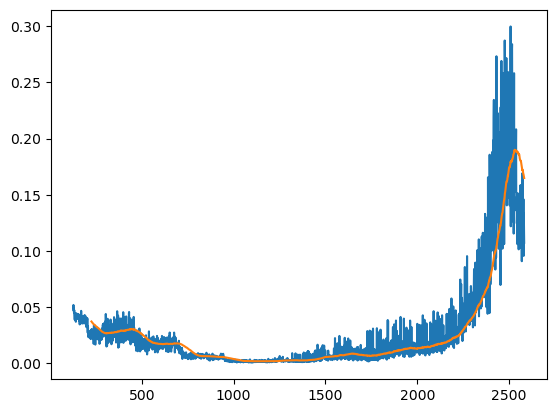

In [371]:
import pandas as pd
plt.plot(lossdata)
edited_loss = pd.DataFrame(lossdata)
mean_loss = edited_loss.rolling(100).mean()
plt.plot(mean_loss)

Text(0, 0.5, 'total rewards')

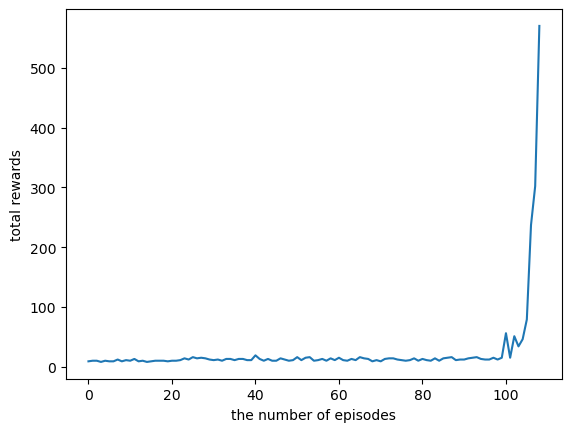

In [372]:
plt.plot(rewarddata)
plt.xlabel("the number of episodes")
plt.ylabel("total rewards")

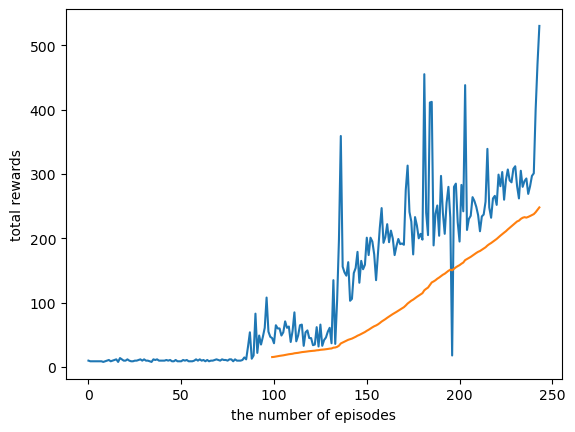

In [336]:
import pandas as pd
edit = pd.DataFrame(rewarddata)
l = edit.rolling(100).mean()
plt.plot(rewarddata)
plt.xlabel("the number of episodes")
plt.ylabel("total rewards")
plt.plot(l)
plt.savefig("reward_tuned.jpg")